In [144]:
# packages need for this scipt

# pip install mne
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install asrpy    #asr algorithm -> automatic noise rejection

# pip install EDFlib-Python  # export data to edf format
# pip install eeglabio # export data to .set format, which can be imported to eeglab 

In [145]:
import os
import mne
import numpy as np
import pandas as pd
import asrpy
import matplotlib.pyplot as plt

In [146]:
# interactive plot 
%matplotlib widget   

# static plot
#%matplotlib inline  

In [147]:
raw = mne.io.read_raw_edf('kym_5min.edf', verbose=0)
raw.resample(sfreq=250)

Sampling frequency of the instance is already 250.0, returning unmodified.


/tmp/ipykernel_410/1449777666.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('kym_5min.edf', verbose=0)


<RawEDF | kym_5min.edf, 4 x 81000 (324.0 s), ~9 kB, data not loaded>

In [148]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG100C-0, EEG100C-1, EEG100C-2, EEG100C-3
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-06-12 18:05:20 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

In [149]:
# raw.plot(duration=60, n_channels=len(raw.ch_names), remove_dc=False)

In [150]:
# raw.plot_psd() 

In [151]:
# load data into memory 
raw.load_data()

Reading 0 ... 80999  =      0.000 ...   323.996 secs...


<RawEDF | kym_5min.edf, 4 x 81000 (324.0 s), ~2.5 MB, data loaded>

In [152]:
# Filtering
#raw_filtered = raw.load_data().filter(l_freq=1, h_freq= 50)
raw.notch_filter(freqs=60)
raw.filter(l_freq=1, h_freq=50)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


<RawEDF | kym_5min.edf, 4 x 81000 (324.0 s), ~2.5 MB, data loaded>

In [153]:
# raw.plot_psd()

In [154]:
# raw.info

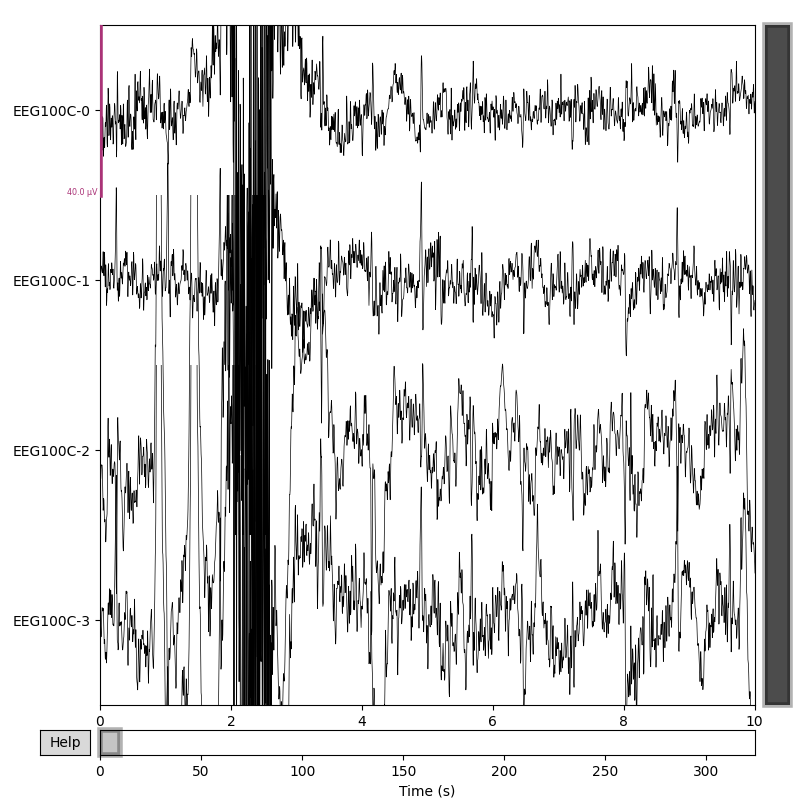

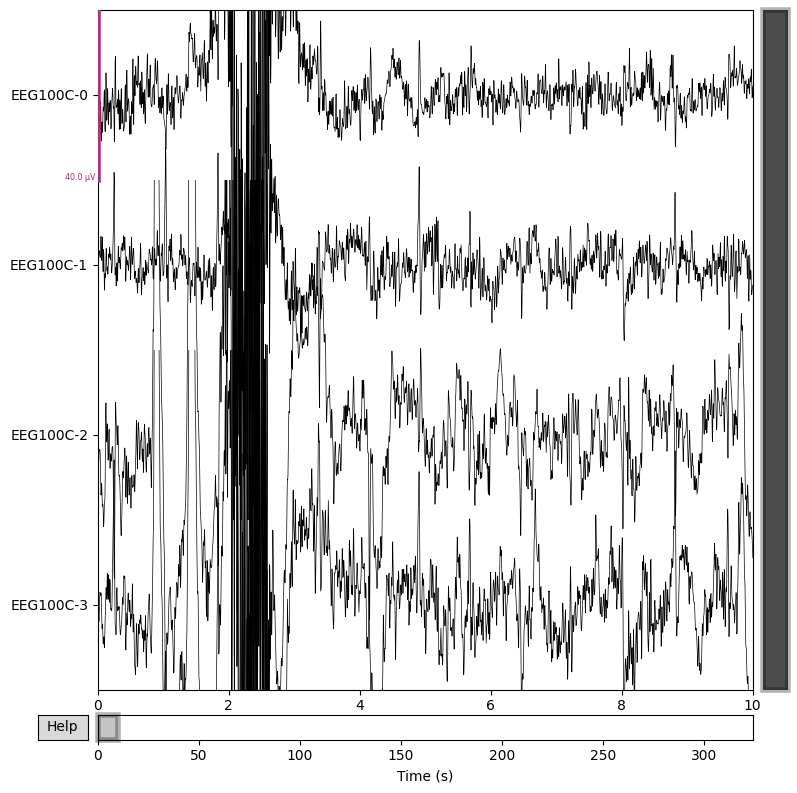

In [155]:
# filtered data 
raw.plot(duration=10, start=0, n_channels=len(raw.ch_names), remove_dc=True)

In [156]:
# use asr algorithm to handle big noise pattern 
import asrpy
asr = asrpy.ASR(
    sfreq=raw.info["sfreq"], 
    blocksize=200, 
    cutoff=2.5, 
    win_len=0.5, 
    win_overlap=0.66
)

asr.fit(raw.load_data())
raw = asr.transform(raw.load_data())

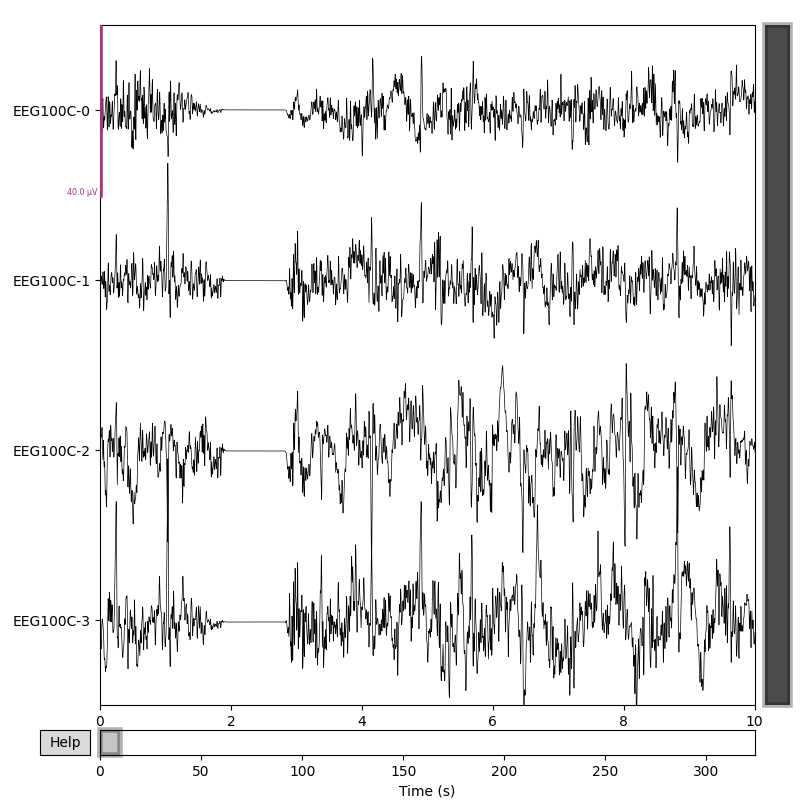

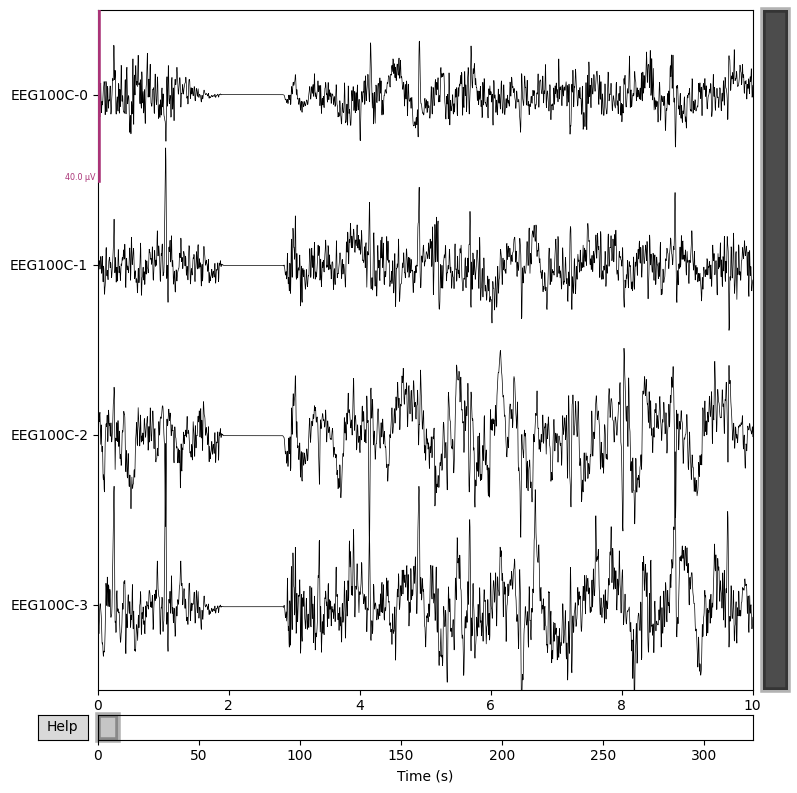

In [157]:
# data after ASR processing
raw.plot(duration=10, start=0, title='with ASR auto rejection')

In [158]:
# detect ECG noise in EEG data, create as events, use annotaion to mark as 'bad' duration to drop 
ecg_events = mne.preprocessing.find_ecg_events(raw, ch_name='EEG100C-1', tstart=0, return_ecg=True)

# set boundary 
onsets = ecg_events[0][: , 0] / raw.info["sfreq"] - 0.05
durations = [0.1] * len(ecg_events[0])
descriptions = ['bad'] * len(ecg_events[0])

#convert event to annotation
ecg_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)

raw.set_annotations(ecg_annot)

Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 354 (average pulse 65 / min.)


<RawEDF | kym_5min.edf, 4 x 81000 (324.0 s), ~2.5 MB, data loaded>

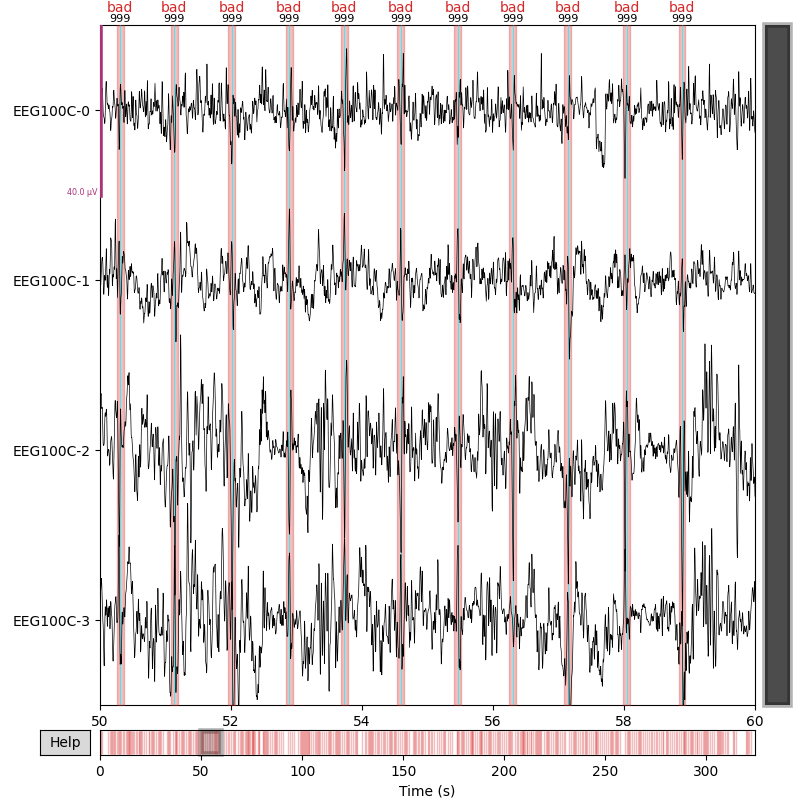

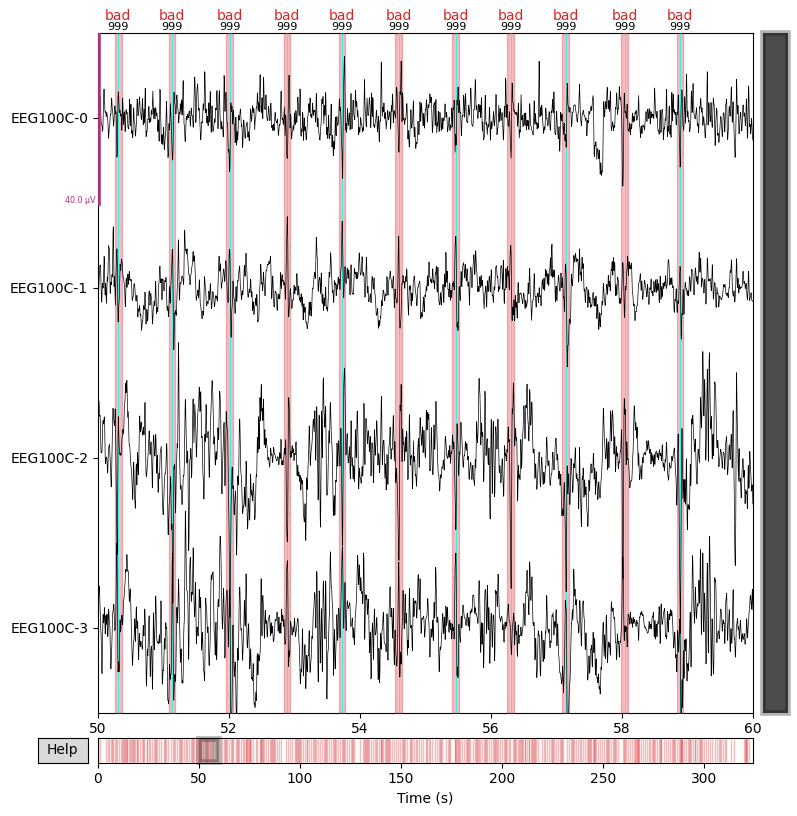

In [159]:
# plot with annotation 
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)

raw.plot(duration=10, start=50, events=ecg_events[0], order=eeg_picks)

In [160]:
len(raw.annotations)

354

In [161]:
# Function to do slicing to crop bad durations out

def reject_bad_segs(raw):
    """ This function rejects all time spans annotated as 'bad' and concatenates the rest"""
    container_list = []
    for index in range(len(raw.annotations)-1): #index start with 0
        copy = raw.copy()
        duration = 0.2

        if index == 0:
            cropped_raw = raw.copy().crop(tmin=0, tmax=raw.annotations[index]['onset']-duration/2)
        else:
            try:
                cropped_raw = raw.copy().crop(tmin= raw.annotations[index]['onset']+duration/2,  tmax= raw.annotations[index +1]['onset']-duration/2)
            except ValueError:
                pass
        
        container_list.append(cropped_raw)

    concatenated_raw = mne.concatenate_raws(container_list)
    return concatenated_raw

In [162]:
crop_raw = reject_bad_segs(raw)

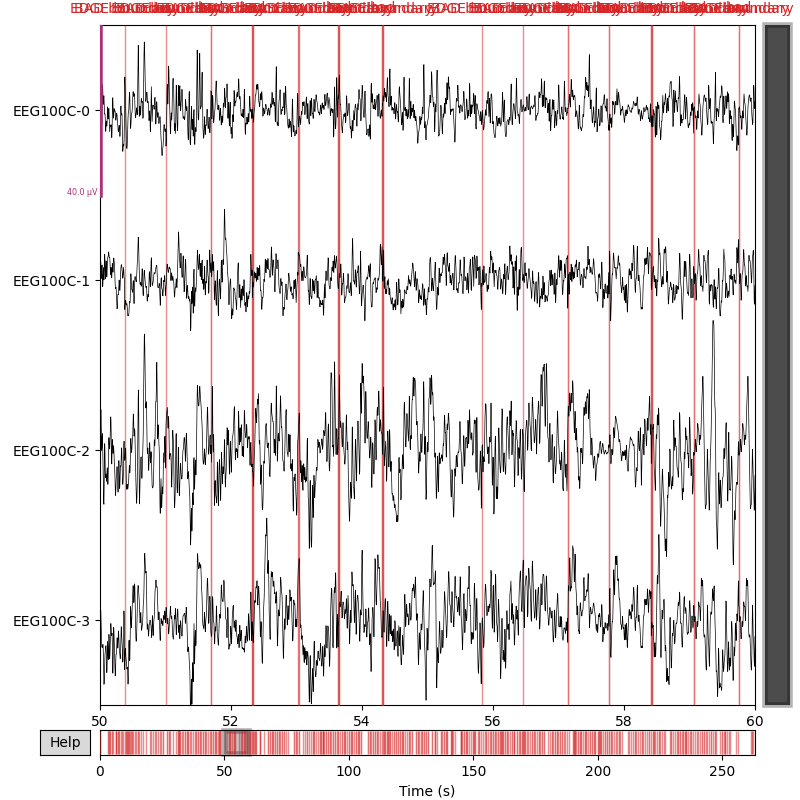

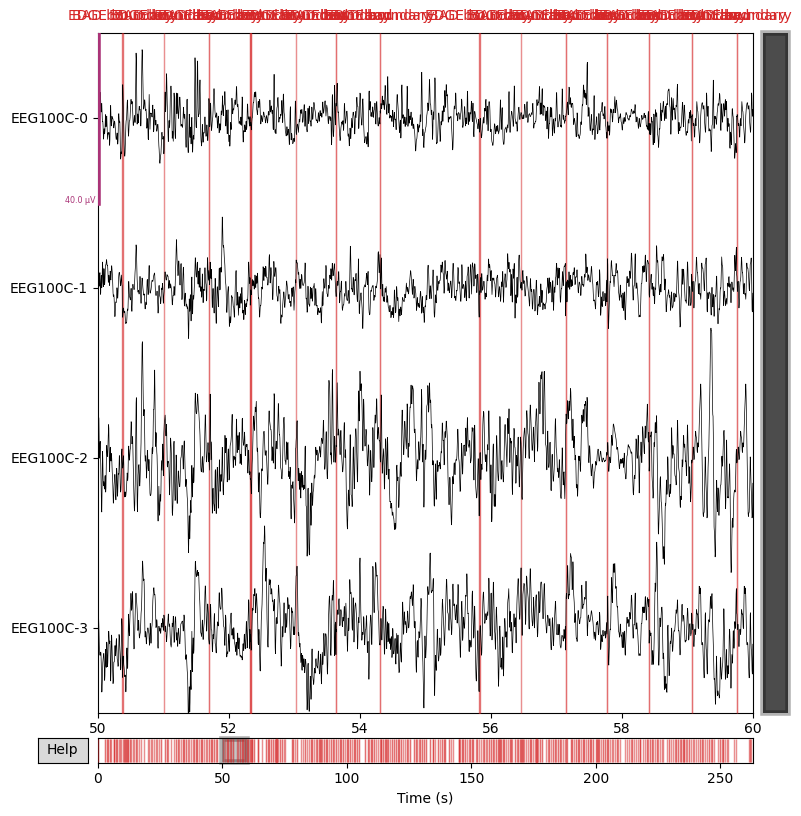

In [163]:
# data with bad duration exclueded
crop_raw.plot(duration=10, start=50)

In [164]:
crop_raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG100C-0, EEG100C-1, EEG100C-2, EEG100C-3
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 50.0 Hz
 meas_date: 2023-06-12 18:05:20 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

In [165]:
# Remove NaN values 
raw_data_no_nan = crop_raw._data[ : , ~np.isnan(crop_raw._data).any(axis=0)]

In [166]:
raw_data_no_nan

array([[ 6.38169142e-21,  2.50564073e-07, -2.26030650e-06, ...,
        -1.36882341e-06,  5.52409535e-06,  1.15008858e-05],
       [-5.06650974e-21, -8.74252519e-07, -1.26062785e-06, ...,
         1.90358539e-06,  5.04451272e-06,  8.33350080e-06],
       [-1.45072686e-20, -1.16477656e-06,  2.48930343e-08, ...,
         1.61948434e-07,  1.14685442e-06,  4.34802980e-06],
       [-5.96293700e-21, -4.78145525e-07, -2.56814970e-06, ...,
        -5.56390255e-06, -2.85034014e-06,  2.19889240e-06]])

In [167]:
# create a tem raw data to distinguish with orignial raw data
tem_raw = mne.io.RawArray(raw_data_no_nan, crop_raw.info)

Creating RawArray with float64 data, n_channels=4, n_times=65792
    Range : 0 ... 65791 =      0.000 ...   263.164 secs
Ready.


In [168]:
# tem_raw.plot_psd()

In [169]:
# tem_raw.plot()

In [170]:
# use asr algorithm again after ECG noise rejection
# with self defined rejecting power (higher than first time)

asr = asrpy.ASR(
    sfreq=tem_raw.info["sfreq"], 
    blocksize=200, 
    cutoff=2.5, 
    win_len=3, 
    win_overlap=0.66
)

asr.fit(tem_raw.load_data())
tem_raw = asr.transform(tem_raw.load_data())

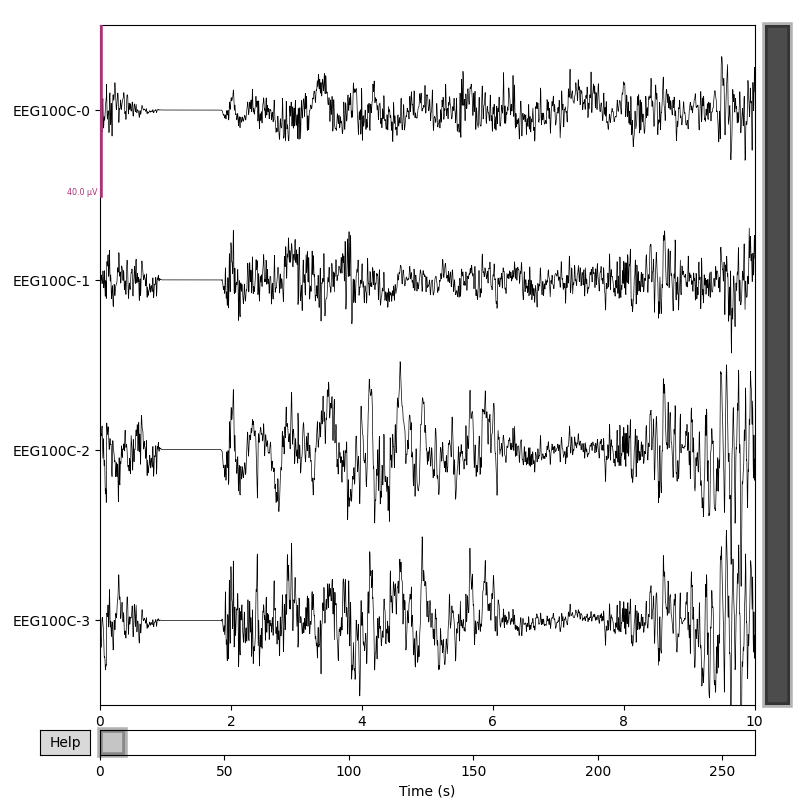

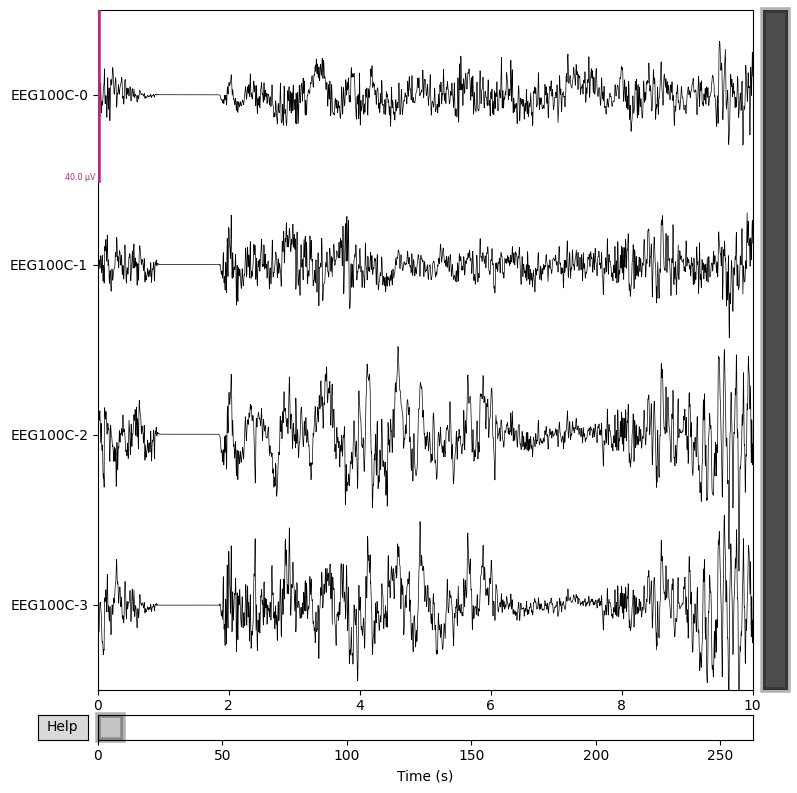

In [171]:
tem_raw.plot(duration=10, start=0, title='with ASR auto rejection')

In [172]:
# tem_raw.info

In [173]:
# save processed data (raw data after filtering and ecg noise rejection, ars noise rejction
tem_raw.export(fname='kym_5min_re.edf', fmt='edf', overwrite=True)
tem_raw.export(fname='kym_5min_re.set', fmt='eeglab', overwrite=True)


Overwriting existing file.
Overwriting existing file.


/tmp/ipykernel_410/792528320.py:2: RuntimeWarning: EDF format requires equal-length data blocks, so 0.832 seconds of zeros were appended to all channels when writing the final block.
  tem_raw.export(fname='kym_5min_re.edf', fmt='edf', overwrite=True)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


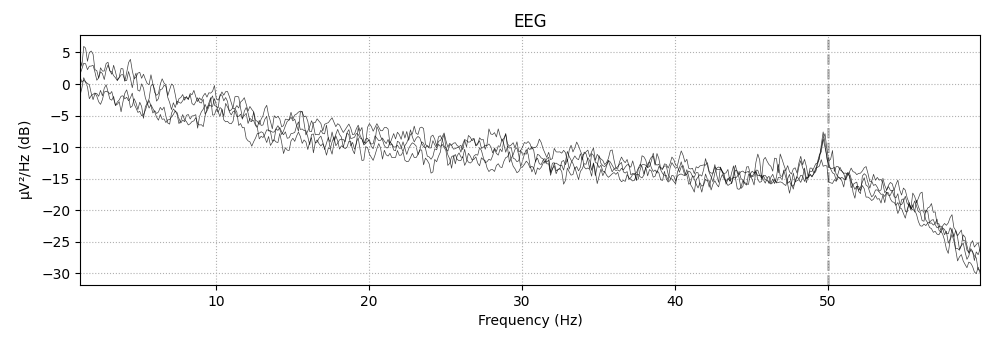

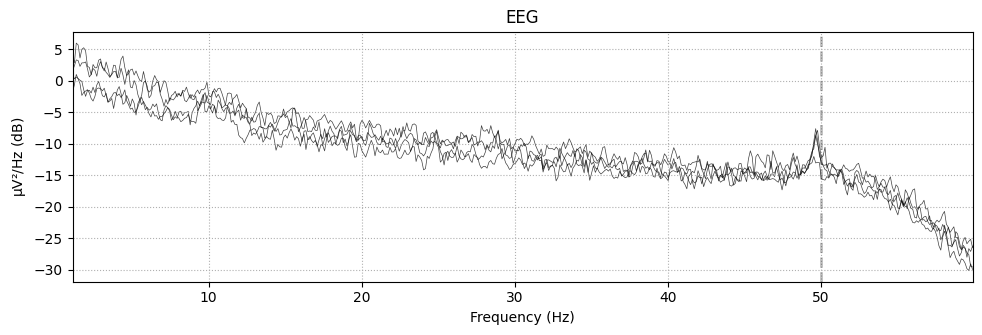

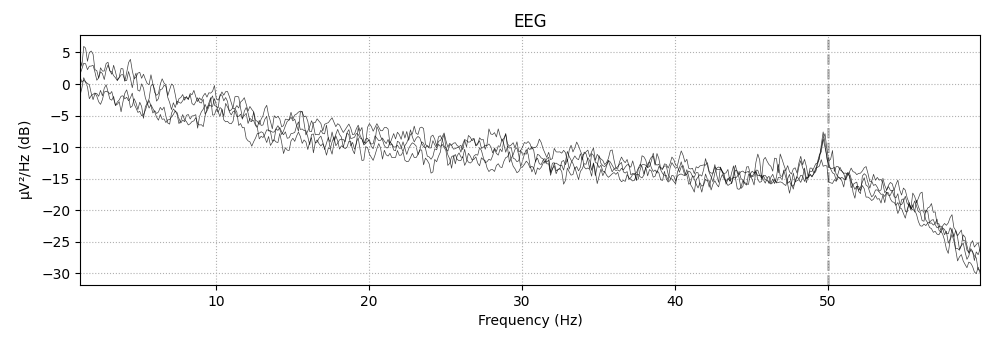

In [174]:
# plot processed data (PSD and Spectrogram)
tem_raw.plot_psd(fmin=1, fmax=60, spatial_colors=False)

In [175]:
# Calculate Absolute and relative power
psds, freqs = mne.time_frequency.psd_array_welch(raw_data_no_nan, sfreq=tem_raw.info['sfreq'])

Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [176]:
# psds.shape, freqs.shape

In [177]:
# Define EEG bands ( Specifing ranges)
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (9, 12),
             'Smr': (13, 15),
             'L-Beta': (16, 20),
             'H-Beta': (21, 30),
             'Gamma': (31, 50)}

col = list(eeg_bands.keys())

# create a dataframe to store abs power results 
power = pd.DataFrame(np.zeros((4, 7)), columns=col, index= ['T7', 'T8', 'Fp1', 'Fp2'])

In [178]:
# get accumulative power for each band
for band in eeg_bands:

    psds, freqs = mne.time_frequency.psd_array_welch(raw_data_no_nan, sfreq=tem_raw.info['sfreq'], fmin=eeg_bands[band][0], fmax=eeg_bands[band][1])
    
    for ch in range(0, len(psds)):
        #ch_avg.append(np.mean(psds[ch]))
        #print(len(psds[ch]))
        power[band][ch] = np.sum(psds[ch]) 

Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [179]:
# get sum of each rows ( To calculate relative power)
power['Total'] = power.sum(axis=1)

In [180]:
power

,Delta,Theta,Alpha,Smr,L-Beta,H-Beta,Gamma,Total
T7,4.434926e-12,2.275997e-12,1.599520e-12,4.973230e-13,8.369179e-13,1.203824e-12,1.447402e-12,1.229591e-11
T8,6.835330e-12,2.378617e-12,1.513131e-12,4.502148e-13,7.151164e-13,1.085043e-12,1.366583e-12,1.434404e-11
Fp1,2.532103e-11,1.180809e-11,1.010446e-11,1.711474e-12,2.481523e-12,3.540819e-12,2.731617e-12,5.769900e-11
Fp2,2.220603e-11,9.691522e-12,1.089104e-11,1.421518e-12,2.078276e-12,2.857337e-12,2.162910e-12,5.130863e-11


In [181]:
# Get relative power
rel_power = np.zeros(power.shape)
for i in range(0, power.shape[0]):
    for j in range(0, power.shape[1]):
        rel_power[i][j] =  power.iloc[i][j] / power.iloc[i][7]

# create a dataframe to store relative power
rel_power = pd.DataFrame(data=rel_power, index=power.index, columns=power.columns)

rel_power.drop(columns='Total', inplace=True)

In [182]:
rel_power

,Delta,Theta,Alpha,Smr,L-Beta,H-Beta,Gamma
T7,0.360683,0.185102,0.130086,0.040446,0.068065,0.097904,0.117714
T8,0.476528,0.165826,0.105488,0.031387,0.049855,0.075644,0.095272
Fp1,0.438847,0.204650,0.175124,0.029662,0.043008,0.061367,0.047343
Fp2,0.432793,0.188887,0.212265,0.027705,0.040505,0.055689,0.042155


<AxesSubplot:>

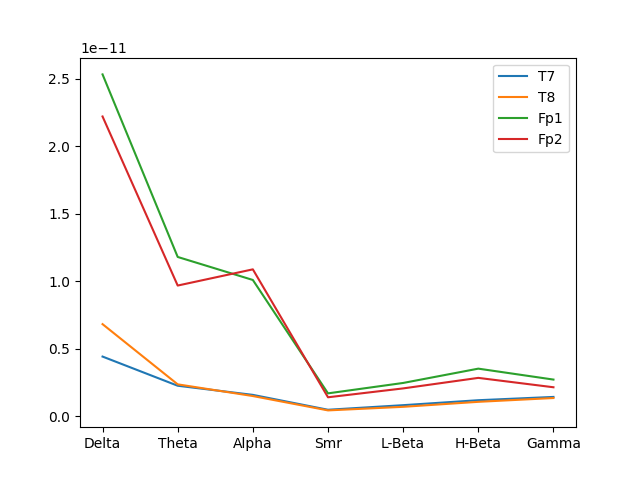

In [183]:
# absolute  power plot
power.iloc[:, :-1].T.plot()  

<AxesSubplot:>

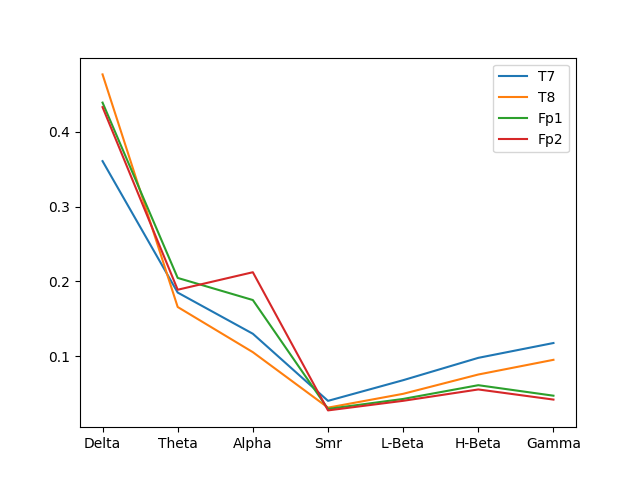

In [184]:
#relative power plot
rel_power.T.plot()

In [185]:
# save results to excel or other tableaue format 
rel_power.to_csv('kym_5min_re.csv')